Importing Libraries

In [6]:
from matplotlib import pyplot as plt
from skimage.io import imread
import numpy as np
import datetime
import math
import os

from tensorflow.keras.utils import to_categorical, Sequence
import tensorflow as tf
import keras
import kagglehub

Checking the kaggle file path to use

In [5]:
# Download latest version
path = kagglehub.dataset_download("romainpessia/artificial-lunar-rocky-landscape-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.02G/5.02G [00:54<00:00, 98.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6


Data Loading

In [7]:
img_dir = '/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/render'
mask_dir = '/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/clean'

# Sorting the files in root directories, Creating and Storing the complete image and mask paths
images = [os.path.join(img_dir, x) for x in sorted(os.listdir(img_dir))]
masks = [os.path.join(mask_dir, x) for x in sorted(os.listdir(mask_dir))]

# First 8000 images to be used for training
X_train = images[:8000]
y_train = masks[:8000]

# Remaining to be used for validation purpose
X_valid = images[8000:-4]
y_valid = masks[8000:-4]

# Saving some for testing purpose (last 4)
X_test = images[-4:]
y_test = masks[-4:]

Dataset Pipeline

In [8]:
class LunarDataset(Sequence):

    # Creating A Constructor
    def __init__(self, x_set, y_set, batch_size, dims, classes):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.img_height, self.img_width = dims
        self.classes = classes

    # Number of Batches
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # Fetching the data in batches by using iter and next opertions
    def __getitem__(self, idx):
        # Getting start and end indexes to create a batch of batch size
        start_index = idx * self.batch_size
        end_index = (idx + 1) * self.batch_size

        # Preparing X and y batches
        batch_x = self.x[start_index : end_index]
        batch_y = self.y[start_index : end_index]

        # Creating Empty lists to append preprocessed Images and Masks Array from the for loop
        xtr = []
        ytr = []

        # For every image and mask in one batch, the following preprocessing is done
        for idx, (filename_x, filename_y) in enumerate(zip(batch_x, batch_y)):

            # Image preprocessing
            img = imread(filename_x)[:self.img_height, :self.img_width, :] / 255.0                           # Read, Slice to dims and Normalize
            img = img.astype(np.float32)                                                                     # Ensure dtype is float32
            xtr.append(img)                                                                                  # Append the image to the xtr list

            # Mask preprocessing
            mask = imread(filename_y, as_gray=True)[:self.img_height, :self.img_width] // 0.07               # Read, Slice, Format
            mask[mask == 3] = 2                                                                              # Convert the pixels that read as 3 to 2
            mask[mask == 10] = 3                                                                             # Convert the pixels that read as 10 to 3
            mask = to_categorical(mask, num_classes=self.classes)                                            # Apply One Hot encoding and create 4 channels
            ytr.append(mask)                                                                                 # Append the mask to the ytr list

        # Converting list to arrays ensuring the dtype of mask is also float32
        xtr = np.array(xtr)
        ytr = np.array(ytr).astype(np.float32)

        # Returning the preprocessed batch of images and respective mask as output
        return xtr, ytr

Dataset Creation

In [9]:
# Parameters
batch_size = 16
dims = (480, 480)
num_classes = 4

# Dataset Creation
train_dataset = LunarDataset(X_train, y_train, batch_size, dims, num_classes)
valid_dataset = LunarDataset(X_valid, y_valid, batch_size, dims, num_classes)

Mask Visualization

In [10]:
# Taking a sample batch from train_dataset
batch = next(iter(train_dataset)) # Batch Size, Height, Width, Channels (Images, Masks)

# Check the shape of batch created --> Images and Masks
print(batch[0].shape) # 16 images in a batch
print(batch[1].shape) # 16 respective masks in a batch

(16, 480, 480, 3)
(16, 480, 480, 4)


Get the mask

In [11]:
# Get the mask
sample = batch[1][1] # Second in the batch

Visualizing the Dataset

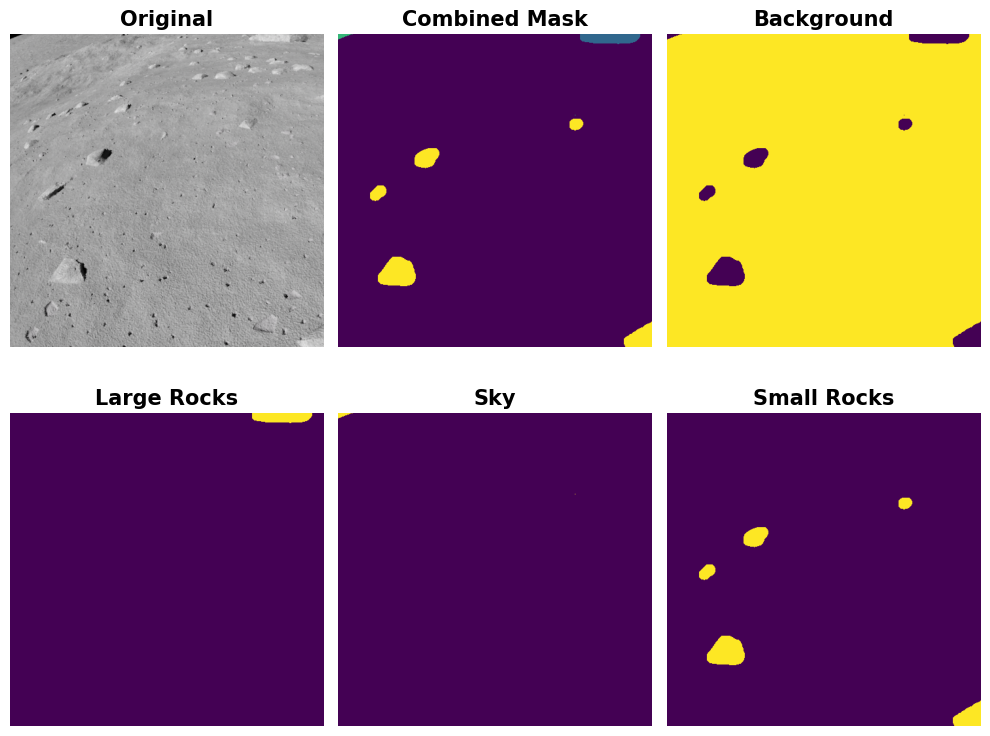

In [12]:
# Creating Subplot for better visualization
fig, ((a1, a2, a3), (a4, a5, a6)) = plt.subplots(2, 3, figsize = (10, 8))

# For different axes and titles
for i, (ax,title) in enumerate(zip((a1, a2, a3, a4, a5, a6),
                                   ('Original', 'Combined Mask', 'Background', 'Large Rocks', 'Sky', 'Small Rocks'))):
    if i == 0:
        ax.imshow(batch[0][1])                    # Second Image in the batch (Original)
    elif i == 1:
        ax.imshow(np.argmax(sample, axis=-1))     # Converts One Hot encoded mask to Integer Encoded Mask (single channel)
    else:
        ax.imshow(sample[:, :, i-2])              # Channel Wise Output from Mask

    # Set Title and turn off the axis
    ax.set_title(title, fontsize=15, weight='bold')
    ax.axis('off')

# Adjust Layout and Display the Subplot
plt.tight_layout()
plt.show()

In [13]:
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.6 MB/s eta 0:00:00


USING SEGMENTATION MODELS LIBRARY:

In [14]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

In [15]:
# Setting the last axis of the tensor as channel axis
tf.keras.backend.set_image_data_format('channels_last')
# Explicitly setting this is not always necessary, as 'channels_last' is the default setting

UNet Model with VGG16 Backbone

In [16]:
# Parameters
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_classes = 4
activation = 'softmax'


model = sm.Unet(backbone_name = BACKBONE,
                input_shape = input_shape,
                classes = n_classes,
                activation = activation,
                encoder_weights = 'imagenet',
                encoder_freeze = True)


# Checking the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 480, 480, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 480, 480, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 480, 480, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 240, 240, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 240, 240, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 240, 240, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 120, 120, 128)  │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 120, 120, 256)  │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 120, 120, 256)  │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 120, 120, 256)  │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 60, 60, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 60, 60, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 60, 60, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 60, 60, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 30, 30, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 30, 30, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 30, 30, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 23,752,708 (90.61 MB)

 Trainable params: 9,033,988 (34.46 MB)

 Non-trainable params: 14,718,720 (56.15 MB)

Model Compilation - Chat made this portion of the code so idk what it fixed from the code below it

Also changed to one epochs

In [17]:
# Hyperparameters
lr = 1e-3
batch_size = 32
epochs = 30

# Setting metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compiling
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),  # Corrected
              metrics=metrics)

# Setting steps per epoch (training in batches)
train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

# Getting the current datetime to use later in the name of files
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Setting callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'models/lunarModel_{current_datetime}.h5',
        monitor='val_iou_score',
        verbose=0,
        mode='max',
        save_best_only=True  # Corrected
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_iou_score",
        mode='max',
        patience=2,
        factor=0.1,
        verbose=0,
        min_lr=1e-6
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor="val_iou_score",
        patience=3,
        verbose=0,
        mode='max'
    )
]

In [ ]:
model_history = model.fit(train_dataset,
                            steps_per_epoch=train_steps,
                            validation_data=valid_dataset,
                            validation_steps=valid_steps,
                            epochs=epochs,
                            callbacks=callbacks
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
192/250 ━━━━━━━━━━━━━━━━━━━━ 55s 952ms/step - f1-score: 0.4839 - iou_score: 0.4439 - loss: 0.3570

Use Glob

In [ ]:
import glob
latest_model = sorted(glob.glob("models/*.h5"))[-1]
files.download(latest_model)

Download

In [ ]:
from google.colab import files

# Replace with actual filename (or use glob to find it)
files.download(f'models/lunarModel_{current_datetime}.h5')

Load the model for later use

In [ ]:
from tensorflow.keras.models import load_model
import segmentation_models as sm

# Load with custom metrics if needed
model = load_model("models/lunarModel_20250324-154230.h5",
                   custom_objects={
                       'iou_score': sm.metrics.IOUScore(threshold=0.5),
                       'f1-score': sm.metrics.FScore(threshold=0.5)
                   })

Model Prediction

In [ ]:
# function to predict result
def predict_image(img_path, mask_path, model):
    H = 480
    W = 480
    num_classes = 4

    img = imread(img_path)
    img = img[:480, :480, :]
    img = img / 255.0
    img = img.astype(np.float32)

    ## Read mask
    mask = imread(mask_path, as_gray = True)
    mask = mask[:480, :480]

    ## Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]


    # calculating IOU score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

In [ ]:
#RANDOMLY CHOOSING A COMBINATION OF IMAGE-MASK:

img_path = f'/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/render/render0050.png'
mask_path = f'/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/clean/clean0050.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title("Predicted mask with IOU score %.2f"%(iou))
ax3.imshow(pred_mask)

plt.show()

In [ ]:
import os
import random
import matplotlib.pyplot as plt

# Directory paths
img_dir = '/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/render/'
mask_dir = '/root/.cache/kagglehub/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset/versions/6/images/clean/'

# List all images and filter png files
image_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

# Randomly choose one image
random_image = random.choice(image_files)

# Construct image and mask paths
img_path = os.path.join(img_dir, random_image)
mask_path = os.path.join(mask_dir, random_image.replace('render', 'clean'))

# Run prediction
img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("True Mask")
ax2.imshow(mask)

ax3.set_title(f"Predicted Mask (IoU: {iou:.2f})")
ax3.imshow(pred_mask)

plt.show()
